In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL
class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform=None, train = True):
        self.images_per_class = 32 if train else 8
        self.start_image = (~train) * 32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.train = train
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = list(filter(lambda s: s.endswith("jpg"), images))
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label-1])
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import torchvision.datasets 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# torch.__version__
#import torchsample as ts

import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler
torch.cuda.current_device()

from torch.optim import lr_scheduler

In [3]:
def validationSplit(trainset, ratio=0.01, random_seed=42):
    trainlen = len(trainset)
    indices = list(range(trainlen))
    split = int(np.floor(ratio*trainlen))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)    
    return train_sampler, valid_sampler

In [4]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.Scale((224,224)),
     #torchvision.transforms.Scale(size, interpolation=2),
     #torchvision.transforms.CenterCrop(size),
     #torchvision.transforms.RandomCrop(size, padding=0),
     #torchvision.transforms.RandomSizedCrop(32, interpolation=2),
     transforms.ToTensor(),
     #transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

trainset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=True)
testset = Caltech256("/datasets/Caltech256/256_ObjectCategories/", transform, train=False)
"""
trainloader = DataLoader(
    dataset = caltech256_train,
    batch_size = 128,
    shuffle = True,
    num_workers = 4
)
"""
batch_size=128

train_sampler, valid_sampler = validationSplit(trainset, ratio=0.1, random_seed=47)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

# trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
pretrained_model = torchvision.models.vgg16(pretrained=True)
print(pretrained_model)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [5]:
class VGG_modified(nn.Module):
    def __init__(self):
        super(VGG_modified, self).__init__()
        pretrained_model = torchvision.models.vgg16(pretrained=True)
        self.pretrained = nn.Sequential(*list(pretrained_model.features.children())[:])
        self.classifier = nn.Sequential(*list(pretrained_model.classifier.children())[:-1])
        #self.lastlayer = nn.Sequential(nn.Linear(4096, 256), nn.ReLU(inplace=True), nn.Softmax())
        self.lastlayer = nn.Sequential(nn.Linear(4096, 256))
        
    def forward(self, x):
        out = self.pretrained(x)
#         print(out.size())
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        out = self.lastlayer(out)
#         print(out.size())
        return out

In [6]:
# pretrained_model = torchvision.models.vgg16(pretrained=True)
# list(pretrained_model.classifier.children())[:]
# print(cnn)

In [7]:
cnn = VGG_modified()
for param in cnn.pretrained.parameters():
    param.requires_grad = False
    
for param in cnn.classifier.parameters():
    param.requires_grad = False
    
for param in cnn.lastlayer.parameters():
    param.requires_grad = True

cnn.cuda()

VGG_modified (
  (pretrained): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride

In [8]:
for m in cnn.lastlayer.modules():
    #if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    if isinstance(m, nn.Linear):
        init.xavier_uniform(m.weight)
        #init.xavier_normal(m.weight)
        print(m)

Linear (4096 -> 256)


In [9]:
def getAllStats(model, loaderlist):
    #[validationloader, testloader]
    model.eval()
    results={}
    criterion = nn.CrossEntropyLoss()
    for i, loader in zip(range(len(loaderlist)),loaderlist):
#         loader.eval()
        correct = 0
        total = 0
        loss = 0
        results[i]={}
        for images, labels in loader:
            labels = labels.long()
            labels = labels.view(labels.size(0))
            labels = labels.cuda()
            
            images = Variable(images).cuda()
            outputs = model(images).cuda()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum()
            
            labels = Variable(labels)
            loss += criterion(outputs, labels).data[0]*images.size(0)
        results[i]['accuracy']=((100 * correct / total))
        results[i]['loss']=((loss / total))
    return results

In [10]:
def getStats(model, loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        labels = labels.long()
        labels = labels.view(labels.size(0))
        labels = labels.cuda()
        
        images = Variable(images).cuda()
        outputs = model(images).cuda()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #print(type(predicted),type(labels))
        correct += (predicted == labels).sum()
    return (100 * correct / total)

In [11]:
# Hyper Parameters
num_epochs = 50
batch_size = 128
learning_rate = 0.001

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.lastlayer.parameters(), lr=learning_rate, weight_decay=0.01)

#scheduler
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,\
                                                  patience=3, verbose=True, threshold=0.0001,
                                                  threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [12]:
train_accuracy=[]
train_loss=[]
validation_accuracy=[]
validation_loss=[]
test_accuracy=[]
test_loss=[]

In [13]:
# Train the Model
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images).cuda()
        labels = labels.long()
        labels = labels.view(labels.size(0))
        labels = Variable(labels).cuda()
        
        #exp_lr_scheduler.step()
        
        optimizer.zero_grad()
        
        outputs = cnn(images)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.data[0]*images.size(0)
        running_corrects += torch.sum(preds == labels.data)
                
        loss.backward()
        optimizer.step()
        
        if (i+1) % 16 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(trainset)//batch_size, loss.data[0]))    
    
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = running_corrects*100 / len(trainloader.dataset)
    train_accuracy.append(epoch_acc)
    train_loss.append(epoch_loss)

    print("\t\t\t\t\t","training\t", "%3.10f  %3.10f" % (epoch_acc, epoch_loss))
    
    results=getAllStats(cnn, [validloader, testloader])
    namedict={ 0:"validation", 1:"testing"}
    for key,val in results.items():
        if(key==0):
            validation_accuracy.append(results[key]['accuracy'])
            validation_loss.append(results[key]['loss'])
        else:
            test_accuracy.append(results[key]['accuracy'])
            test_loss.append(results[key]['loss'])
        print("\t\t\t\t\t",namedict[key],"\t", "%3.10f  %3.10f" % (results[key]['accuracy'], results[key]['loss']))
        
    pla_lr_scheduler.step(validation_loss[-1])

Epoch [1/50], Iter [16/64] Loss: 3.7359
Epoch [1/50], Iter [32/64] Loss: 1.9740
Epoch [1/50], Iter [48/64] Loss: 1.7383
					 training	 36.5600585938  2.6581039704
					 validation 	 68.0097680098  1.4013170710
					 testing 	 72.8027343750  1.2814477049
Epoch [2/50], Iter [16/64] Loss: 0.7791
Epoch [2/50], Iter [32/64] Loss: 0.9658
Epoch [2/50], Iter [48/64] Loss: 0.9960
					 training	 74.9511718750  0.7990506377
					 validation 	 70.3296703297  1.3274239603
					 testing 	 74.4628906250  1.1987538673
Epoch [3/50], Iter [16/64] Loss: 0.6604
Epoch [3/50], Iter [32/64] Loss: 0.6706
Epoch [3/50], Iter [48/64] Loss: 0.6677
					 training	 81.7626953125  0.5966511986
					 validation 	 72.0390720391  1.2680433967
					 testing 	 76.1718750000  1.1295078099
Epoch [4/50], Iter [16/64] Loss: 0.5089
Epoch [4/50], Iter [32/64] Loss: 0.5389
Epoch [4/50], Iter [48/64] Loss: 0.5737
					 training	 84.7412109375  0.4666979003
					 validation 	 72.2832722833  1.2401604753
					 testing 	 76.02539

Epoch [32/50], Iter [32/64] Loss: 0.1935
Epoch [32/50], Iter [48/64] Loss: 0.2577
					 training	 89.9047851562  0.1870242164
					 validation 	 73.6263736264  1.1528077741
					 testing 	 78.2226562500  1.0070948452
Epoch [33/50], Iter [16/64] Loss: 0.1662
Epoch [33/50], Iter [32/64] Loss: 0.2212
Epoch [33/50], Iter [48/64] Loss: 0.2139
					 training	 89.9047851562  0.1859965145
					 validation 	 74.3589743590  1.1502929943
					 testing 	 78.1738281250  1.0107151419
Epoch [34/50], Iter [16/64] Loss: 0.1834
Epoch [34/50], Iter [32/64] Loss: 0.2067
Epoch [34/50], Iter [48/64] Loss: 0.1903
					 training	 89.9658203125  0.1855100446
					 validation 	 74.4810744811  1.1486956836
					 testing 	 78.1738281250  1.0122245699
Epoch [35/50], Iter [16/64] Loss: 0.1920
Epoch [35/50], Iter [32/64] Loss: 0.2385
Epoch [35/50], Iter [48/64] Loss: 0.2241
					 training	 89.8925781250  0.1866453742
					 validation 	 74.4810744811  1.1493221032
					 testing 	 77.6855468750  1.0171221197
Epoch    

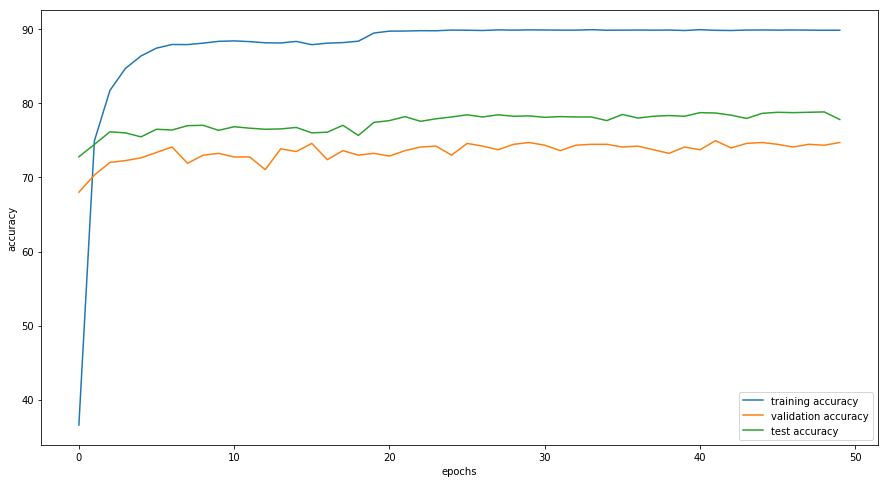

In [14]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

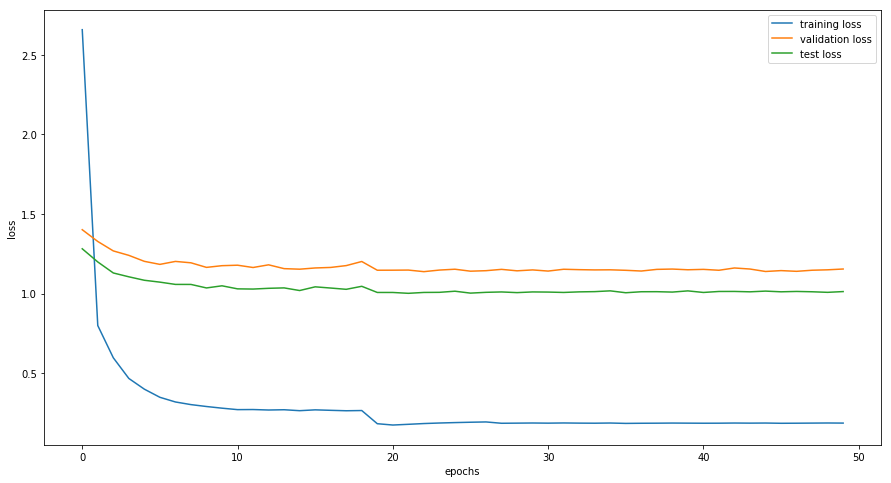

In [15]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [21]:
import pickle
# Save the Trained Model
torch.save(cnn.state_dict(), 'VGG-final-77.pkl')

In [22]:
import pickle
f = open("plots-vgg-full-network", "wb")
pickle.dump(train_accuracy, f)
pickle.dump(train_loss, f)
pickle.dump(validation_accuracy, f)
pickle.dump(validation_loss, f)
pickle.dump(test_accuracy, f)
pickle.dump(test_loss, f)
f.close()

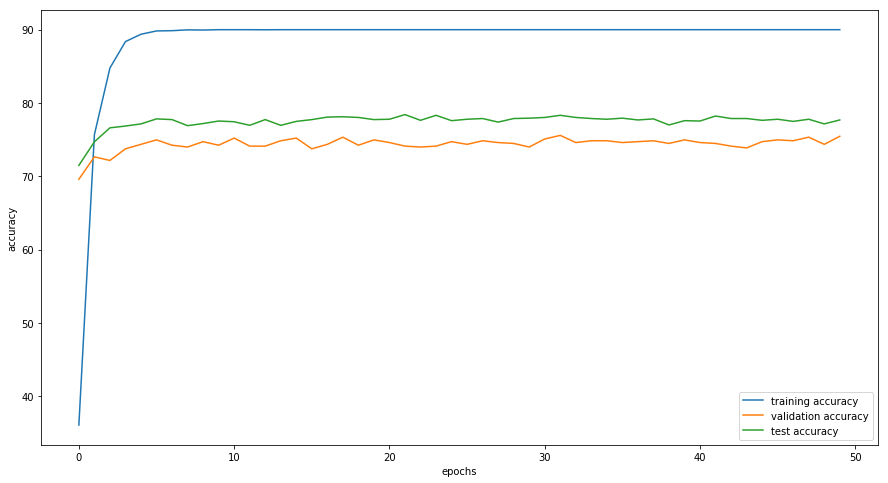

In [23]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_accuracy, label='training accuracy')
plt.plot(range(len(train_accuracy)),validation_accuracy, label='validation accuracy')
plt.plot(range(len(train_accuracy)),test_accuracy, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

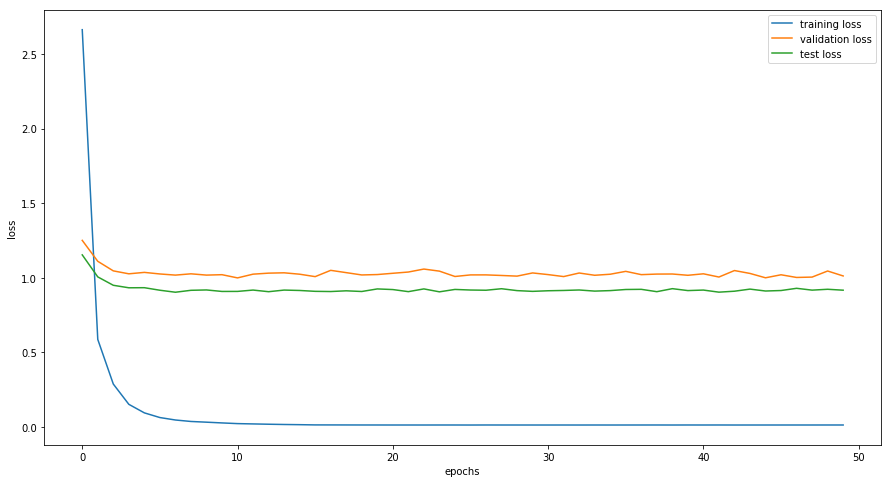

In [24]:
plt.figure(figsize=(15,8))
plt.plot(range(len(train_accuracy)),train_loss, label='training loss')
plt.plot(range(len(train_accuracy)),validation_loss, label='validation loss')
plt.plot(range(len(train_accuracy)),test_loss, label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()